## Implementation d'un système de tarification dynamique utilisant le Reinforcement Learning avec l'algorithme PPO (Proximal Policy Optimization) de Stable Baselines3.

L'objectif est d'apprendre une politique optimale pour ajuster les prix des courses
en fonction des conditions du marché et des caractéristiques de la demande.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gradio as gr


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

import gymnasium as gym
from gymnasium.spaces import Box, Dict

In [3]:
PATH = 'dynamic_pricing.csv'
df = pd.read_csv(PATH)
df.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


In [4]:
df.describe()

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,60.372000,27.076000,50.031000,4.257220,99.58800,372.502623
std,23.701506,19.068346,29.313774,0.435781,49.16545,187.158756
min,20.000000,5.000000,0.000000,3.500000,10.00000,25.993449
25%,40.000000,11.000000,25.000000,3.870000,59.75000,221.365202
50%,60.000000,22.000000,51.000000,4.270000,102.00000,362.019426
75%,81.000000,38.000000,75.000000,4.632500,143.00000,510.497504
max,100.000000,89.000000,100.000000,5.000000,180.00000,836.116419


In [5]:
df.nunique()

Number_of_Riders             81
Number_of_Drivers            79
Location_Category             3
Customer_Loyalty_Status       3
Number_of_Past_Rides        101
Average_Ratings             151
Time_of_Booking               4
Vehicle_Type                  2
Expected_Ride_Duration      171
Historical_Cost_of_Ride    1000
dtype: int64

In [6]:
df.isnull().sum()

Number_of_Riders           0
Number_of_Drivers          0
Location_Category          0
Customer_Loyalty_Status    0
Number_of_Past_Rides       0
Average_Ratings            0
Time_of_Booking            0
Vehicle_Type               0
Expected_Ride_Duration     0
Historical_Cost_of_Ride    0
dtype: int64

In [7]:
def get_data_dictionary(data):
    data_dict = pd.DataFrame(columns=['Column', 'Count', 'Unique Values', 'Range', 'Null values', 'Possible Values'])
    
    for col in data.columns:
        count = data[col].shape[0]  # Total count of rows
        unique_values = data[col].nunique()  # Number of unique values in the column
        
        # Defining the range
        if pd.api.types.is_numeric_dtype(data[col]):  # Check if column is numeric
            if unique_values > 1:
                range = f"{data[col].min()} - {data[col].max()}"
        else:
            range = np.nan  
        nulls = data[col].isna().sum() 
        
        # Sampling possible values 
        values = list(data[col].dropna().sample(frac=0.25, replace=False, random_state=42))
        values = list(set(values))[:5]  # Show only up to 5 unique values for preview
        data_dict.loc[len(data_dict)] = [col,count,unique_values,range,nulls,values]
    
    return data_dict

In [8]:
data_dict = get_data_dictionary(df)
data_dict

,Column,Count,Unique Values,Range,Null values,Possible Values
0,Number_of_Riders,1000,81,20 - 100,0,"[21, 22, 23, 24, 25]"
1,Number_of_Drivers,1000,79,5 - 89,0,"[5, 6, 7, 8, 9]"
2,Location_Category,1000,3,NaN,0,"[Urban, Rural, Suburban]"
3,Customer_Loyalty_Status,1000,3,NaN,0,"[Gold, Regular, Silver]"
4,Number_of_Past_Rides,1000,101,0 - 100,0,"[0, 1, 2, 3, 4]"
5,Average_Ratings,1000,151,3.5 - 5.0,0,"[3.53, 4.78, 3.57, 4.98, 4.29]"
6,Time_of_Booking,1000,4,NaN,0,"[Afternoon, Morning, Night, Evening]"
7,Vehicle_Type,1000,2,NaN,0,"[Premium, Economy]"
8,Expected_Ride_Duration,1000,171,10 - 180,0,"[11, 12, 14, 16, 17]"
9,Historical_Cost_of_Ride,1000,1000,25.993449448411635 - 836.1164185613576,0,"[517.9444619823878, 518.9547629602604, 510.626..."


In [9]:
# Définition des caractéristiques catégorielles et numériques
cat_features = ['Location_Category', 'Customer_Loyalty_Status', 'Time_of_Booking', 'Vehicle_Type']
num_features = ['Number_of_Riders', 'Number_of_Drivers', 'Number_of_Past_Rides', 
                'Average_Ratings', 'Expected_Ride_Duration']

In [10]:
# Pipeline de pretraitement
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(), cat_features)
    ])

# Ajustement du prétraitement sur l'ensemble des données
preprocessor.fit(df)

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [11]:
class PricingEnv(gym.Env):
    
    def __init__(self, df, preprocessor):
        super().__init__()
        
        # Data initialization
        self.df = df.reset_index(drop=True)
        self.preprocessor = preprocessor
        self.current_step = 0
        
        # Calculate empirical price elasticity from historical data
        self.elasticity = self.estimate_price_elasticity()
        
        
        # Action space: price multiplier between 0.5x and 2.0x historical price
        self.action_space = Box(low=0.5, high=2.0, shape=(1,), dtype=np.float32)
        
        # Observation space: preprocessed feature vector
        num_features = preprocessor.transform(df.iloc[[0]]).shape[1]
        self.observation_space = Box(low=-np.inf, high=np.inf, 
                                   shape=(num_features,), dtype=np.float32)
        
        # Initial state
        self.state = self.preprocessor.transform(df.iloc[[self.current_step]])[0]

        # Reward
        self.rewards_history = []
        # log
        self.log = []
    
    def estimate_price_elasticity(self):
        """Calculate price elasticity from historical data"""
        prices = self.df['Historical_Cost_of_Ride'].values
        demand = self.df['Number_of_Riders'].values
        
        # Calculate percentage changes
        delta_p = np.diff(prices)
        delta_q = np.diff(demand)
        
        # Averages for midpoint method
        p_avg = (prices[1:] + prices[:-1]) / 2
        q_avg = (demand[1:] + demand[:-1]) / 2
        
        # Percentage changes
        pct_delta_p = delta_p / p_avg
        pct_delta_q = delta_q / q_avg
        
        # Elasticity estimates
        elasticity = pct_delta_q / pct_delta_p
        
        # Nettoyage
        elasticity = elasticity[np.isfinite(elasticity)]
        elasticity = elasticity[(elasticity < 0) & (np.abs(elasticity) < 5)]

        if len(elasticity) == 0:
            print("Aucune élasticité valide trouvée, valeur par défaut utilisée.")
            return -1.0  # fallback par défaut
            print("Elasticity: ", elasticity)
        
        # Clean and return median elasticity (more robust than mean)
        elasticity = np.median(elasticity[np.isfinite(elasticity)])
        return elasticity
    
    def reset(self, *, seed=None, options=None):
        """Reset environment to initial state"""
        super().reset(seed=seed)
        self.current_step = 0
        self.state = self.preprocessor.transform(
            self.df.iloc[[self.current_step]])[0].astype(np.float32)
        self.rewards_history = []
        self.log = []
        return self.state, {}
    
    def estimate_quantity_demanded(self, price, base_price):

        q0 = self.df.iloc[self.current_step]['Number_of_Riders']
        
        # Assurer que l'élasticité est négative et significative
        elasticity = -abs(self.elasticity)
        price_ratio = price / base_price
        
        # Calcul de la demande avec élasticité négative
        new_quantity = q0 * price_ratio ** elasticity
        
        return new_quantity
    
    def step(self, action):
        """Execute one environment step"""
        current_features = self.df.iloc[self.current_step]
        historical_price = current_features['Historical_Cost_of_Ride']
        
        # Apply price multiplier action
        new_price = historical_price * action[0]
        
        # print(f"Multiplicateur choisi : {action[0]}")
        
        # Estimate demand using elasticity model
        quantity = self.estimate_quantity_demanded(new_price, historical_price)
        
        
        # Calculate reward (revenue = price × quantity)
        reward = new_price * quantity
        self.rewards_history.append(reward)
        
        # Progress environment
        self.current_step += 1
        terminated = self.current_step >= len(self.df) - 1
        truncated = False
        
        # Update state
        if not terminated:
            self.state = self.preprocessor.transform(
                self.df.iloc[[self.current_step]])[0].astype(np.float32)
        else:
            self.state = np.zeros_like(self.state, dtype=np.float32)
            
        self.log.append({
            "step": self.current_step,
            "price": float(new_price),
            "quantity": float(quantity),
            "reward": float(reward),
            "action": float(action[0])
        })
        
        return self.state, reward, terminated, truncated, {}
    
    def render(self):
        """Optional visualization"""
        pass

In [12]:
# Création de l'environnement
env = PricingEnv(df, preprocessor)

# Validation de l'environnement
check_env(env) 

# Définition et entraînement du modèle
model = PPO("MlpPolicy", env, verbose=1, 
            learning_rate=0.0003,
            n_steps=2048,
            batch_size=64,
            n_epochs=10,
            gamma=0.99,
            gae_lambda=0.95,
            ent_coef=0.0,
            clip_range=0.2)
model.learn(total_timesteps=10000)

C:\Users\ousma\PycharmProjects\devoir_rl\.venv\Lib\site-packages\stable_baselines3\common\env_checker.py:462: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 999      |
|    ep_rew_mean     | 1.96e+07 |
| time/              |          |
|    fps             | 116      |
|    iterations      | 1        |
|    time_elapsed    | 17       |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 999           |
|    ep_rew_mean          | 1.97e+07      |
| time/                   |               |
|    fps                  | 113           |
|    iterations           | 2             |
|    time_elapsed         | 36            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 1.4546094e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2       

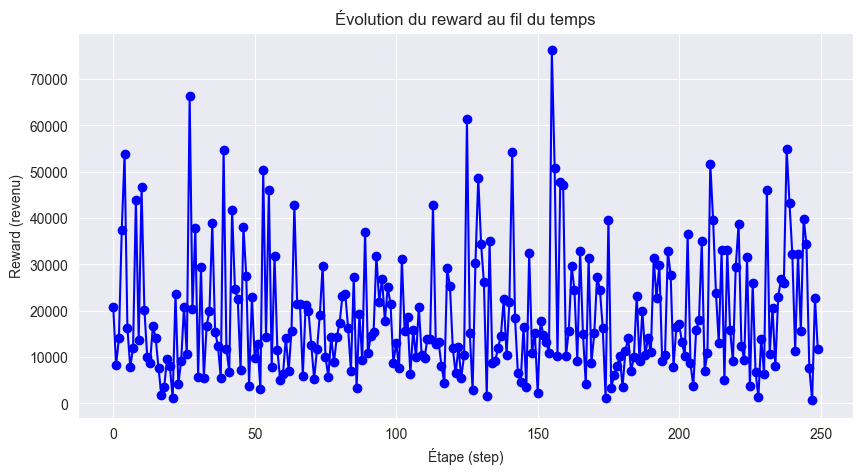

In [13]:
rewards = env.rewards_history

plt.figure(figsize=(10, 5))
plt.plot(rewards, marker='o', linestyle='-', color='blue')
plt.xlabel("Étape (step)")
plt.ylabel("Reward (revenu)")
plt.title("Évolution du reward au fil du temps")
plt.grid(True)
plt.show()


In [14]:
def run_dashboard(env):
    if not hasattr(env, "log") or not env.log:
        raise gr.Error("Aucune donnée dans `env.log`. Lance une simulation d'abord.")

    df_log = pd.DataFrame(env.log)

    # Fonction pour tracer les courbes
    def show_plot(curve_type):
        fig, ax = plt.subplots()
        ax.plot(df_log["step"], df_log[curve_type.lower()], marker='o', label=curve_type)
        ax.set_xlabel("Étape")
        ax.set_ylabel(curve_type)
        ax.set_title(f"{curve_type} par step")
        ax.grid(True)
        ax.legend()
        return fig

    # Fonction pour tester un multiplicateur de prix à un step donné
    def simulate_custom_price(step, multiplier):
        if step < 0 or step >= len(env.df):
            raise gr.Error(f"Step invalide. Doit être entre 0 et {len(env.df) - 1}.")
        if multiplier < 0.5 or multiplier > 2.0:
            raise gr.Error("Le multiplicateur doit être entre 0.5 et 2.0")

        row = env.df.iloc[step]
        base_price = row["Historical_Cost_of_Ride"]
        q0 = row["Number_of_Riders"]
        elasticity = -abs(env.elasticity)
        price = base_price * multiplier
        quantity = q0 * (price / base_price) ** elasticity
        revenue = price * quantity

        return {
            "🎯 Prix proposé (€)": round(price, 2),
            "👥 Quantité demandée estimée": int(quantity),
            "💰 Revenu estimé (€)": round(revenue, 2)
        }

    # Interface Gradio
    with gr.Blocks() as demo:
        gr.Markdown("## 📈 Dashboard Tarification Dynamique (RL + PPO)")
        gr.Dataframe(df_log.head(), label="Aperçu des résultats de simulation")

        with gr.Row():
            curve_selector = gr.Radio(["Reward", "Price", "Quantity"], label="Choisir une courbe à afficher")
        plot_output = gr.Plot()
        curve_selector.change(fn=show_plot, inputs=curve_selector, outputs=plot_output)

        gr.Markdown("---")
        gr.Markdown("## 🔍 Tester un prix personnalisé")

        with gr.Row():
            step_input = gr.Number(label="Étape (ligne de données)", value=0, precision=0)
            multiplier_input = gr.Slider(minimum=0.5, maximum=2.0, step=0.05,
                                         label="Multiplicateur de prix", value=1.0)

        simulate_button = gr.Button("Simuler")
        simulate_result = gr.JSON(label="Résultat de la simulation")

        simulate_button.click(fn=simulate_custom_price,
                              inputs=[step_input, multiplier_input],
                              outputs=simulate_result)

    demo.launch()

In [15]:
run_dashboard(env)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [94]:
# Sauvegarde du modèle entraîné
#model.save("dynamic_pricing_ppo")